In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
import torchvision
import numpy as np 

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_ds=torchvision.datasets.CIFAR10('data',train=True,transform=torchvision.transforms.ToTensor(),download=False)
test_ds=torchvision.datasets.CIFAR10('data',train=False,transform=torchvision.transforms.ToTensor(),download=False)

In [4]:
# import torch.utils
# help(torch.utils.data.DataLoader)

In [5]:
import torch.utils


batch_size=32
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size=batch_size)

In [6]:
imgs,labels=next(iter(train_dl))
imgs.shape

torch.Size([32, 3, 32, 32])

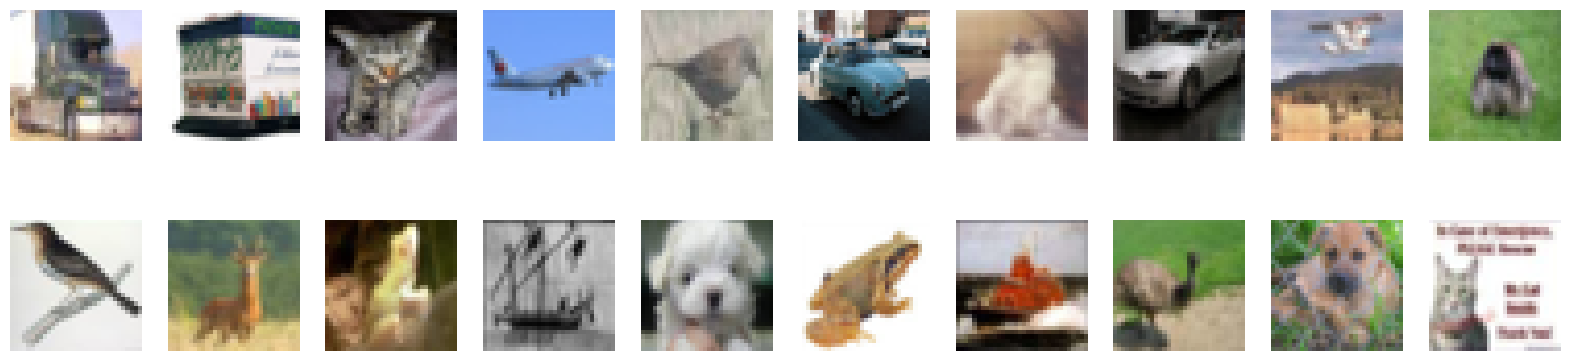

In [7]:
plt.figure(figsize=(20,5))
for i, imgs in enumerate(imgs[:20]):
    npimg=imgs.numpy().transpose((1,2,0))
    plt.subplot(2,10,i+1)
    plt.imshow(npimg,cmap=plt.cm.binary)
    plt.axis('off')

In [8]:
from torch.nn import functional as F 
num_classes=10
class Model(nn.Module):
    def __init__(self) :
        super().__init__()
        self.conv1=nn.Conv2d(3,64,kernel_size=3)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(64,64,kernel_size=3)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        self.conv3=nn.Conv2d(64,128,kernel_size=3)
        self.pool3=nn.MaxPool2d(kernel_size=2)
        
        self.fc1=nn.Linear(512,256)
        self.fc2=nn.Linear(256,num_classes)
    
    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=self.pool3(F.relu(self.conv3(x)))
        
        x=torch.flatten(x,start_dim=1)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x



In [9]:
from torchinfo import summary
model=Model().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            1,792
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            36,928
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            73,856
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            131,328
├─Linear: 1-8                            2,570
Total params: 246,474
Trainable params: 246,474
Non-trainable params: 0

In [10]:
loss_fn=nn.CrossEntropyLoss()
learn_rate=1e-2
opt=torch.optim.SGD(model.parameters(),lr=learn_rate)

In [11]:
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)

    train_loss,train_acc=0,0

    for X,y in dataloader:
        X,y=X.to(device),y.to(device)
        
        pred=model(X)
        loss=loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc+=(pred.argmax(1)==y).type(torch.float).sum().item()
        train_loss+=loss.item()

    train_acc/=size
    train_loss/=num_batches
    return train_acc,train_loss


In [12]:
def test(dataloader,model,loss_fn):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)

    test_loss,test_acc=0,0

    with torch.no_grad():
        for imgs,target in dataloader:
            imgs,target=imgs.to(device),target.to(device)

            target_pred=model(imgs)
            loss=loss_fn(target_pred,target)

            test_loss+=loss.item()
            test_acc+=(target_pred.argmax(1)==target).type(torch.float).sum().item()

        test_acc/=size
        test_loss/=num_batches
    return test_acc,test_loss

In [13]:
epochs=10
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

for epoch in range(epochs):
    model.train()
    epoch_train_acc,epoch_train_loss=train(test_dl,model,loss_fn,opt)

    model.eval()
    epoch_test_acc,epoch_test_loss=test(test_dl,model,loss_fn)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)

    template=('Epoch:{:2d},Train_acc:{:.1f}%,Train_loss:{:.3f},Test_acc:{:.1f}%,Test_loss:{:.3f}')
    print(template.format(epoch+1,epoch_train_acc*100,epoch_train_loss,epoch_test_acc*100,epoch_test_loss))
print('DONE')

Epoch: 1,Train_acc:11.5%,Train_loss:2.301,Test_acc:11.8%,Test_loss:2.299
Epoch: 2,Train_acc:11.3%,Train_loss:2.297,Test_acc:11.6%,Test_loss:2.294
Epoch: 3,Train_acc:12.0%,Train_loss:2.289,Test_acc:12.1%,Test_loss:2.282
Epoch: 4,Train_acc:14.5%,Train_loss:2.268,Test_acc:15.6%,Test_loss:2.246
Epoch: 5,Train_acc:20.2%,Train_loss:2.181,Test_acc:17.6%,Test_loss:2.192
Epoch: 6,Train_acc:22.7%,Train_loss:2.072,Test_acc:18.4%,Test_loss:2.234
Epoch: 7,Train_acc:24.0%,Train_loss:2.032,Test_acc:19.9%,Test_loss:2.170
Epoch: 8,Train_acc:25.9%,Train_loss:1.999,Test_acc:21.9%,Test_loss:2.125
Epoch: 9,Train_acc:27.4%,Train_loss:1.969,Test_acc:23.0%,Test_loss:2.095
Epoch:10,Train_acc:28.8%,Train_loss:1.940,Test_acc:24.0%,Test_loss:2.065
DONE


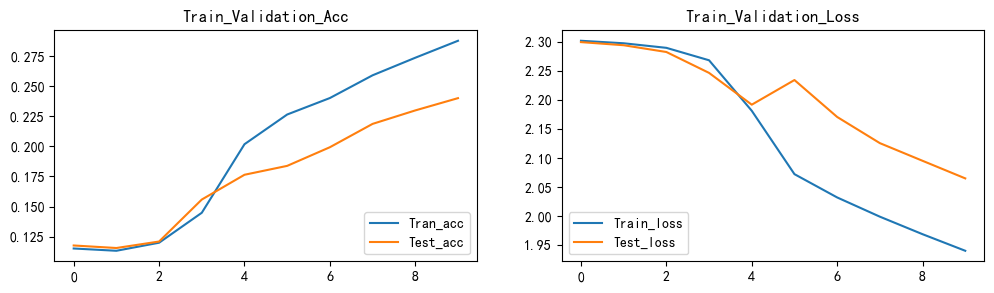

In [15]:
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.dpi']=100

epochs_range=range(epochs)

plt.figure(figsize=(12,3))

plt.subplot(1,2,1)

plt.plot(epochs_range,train_acc,label="Tran_acc")
plt.plot(epochs_range,test_acc,label="Test_acc")
plt.legend(loc='lower right')
plt.title("Train_Validation_Acc")

plt.subplot(1,2,2)

plt.plot(epochs_range,train_loss,label="Train_loss")
plt.plot(epochs_range,test_loss,label="Test_loss")
plt.legend(loc='lower left')
plt.title("Train_Validation_Loss")

plt.show()